# Сборный проект: анализ продаж компьютерных игр

В данном проекте планируется провести анализ данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах, доступнных из открытых источников. Мы попробуем выявить закономерности, определяющие успешность игры. 
Данные представлены до 2016 года, нужно спланировать рекламную кампанию на 2017-й. 

## 1. Изучение данных из файла

In [1]:
import pandas as pd  #импорт библиотек
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
try:
    games = pd.read_csv('games.csv') # чтение файла локально
except:
    games = pd.read_csv('/datasets/games.csv')  # чтение файла с сервера

In [3]:
display(games.head()) # отображение первых 5 строк таблицы и информации о ней 
print(games.info())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


В исходной таблице 10 столбцов и 16715 строчек. Названия столбцов не приведены к нижнему регистру - это предстоит сделать, а ещё в данных есть пропуски. Два пропуска есть даже в столбце с названиями игр - видимо придется работать с безымянными образцами. Нужно поработать с типами данных, год релиза указан в формате числа с плавающей точкой, рейтинг пользователей - объектом.

## 2.  Предобработка данных

### Названия столбцов
Сначала попробуем разобраться с названиями столбцов, потом с типами данных, пропуски заполним ближе к концу предобработки

In [4]:
col_list = games.columns.values.tolist() #список названий столбцов
print(col_list)
for i in range(len(col_list)): # в цикле приводим их к нижнему регистру
    col_list[i] = col_list[i].lower()
print(col_list)
games.columns = col_list # заменяем на нужный список
display(games.head())

['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales', 'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating']
['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Теперь все названия столбцов в нижнем регистре

### Пропуски

#### Пропуски в названиях игр 

In [5]:
display(games[games['name'].isna()])
games = games.dropna(subset=['name'])
display(games[games['name'].isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Две безымянных игры 1993 года выпуска без рейтингов и жанров лучше удалить

#### Пропуски в годах релиза игр 

In [6]:
name_year = list(games[games['year_of_release'].isna()]['name']) # список названий игр, где пропущен год выпуска
name_year_filler = []
for name in name_year:
    for c in name:
        if c in '0123456789':
            name_year_filler.append(name) # список названий игр, где присутствуют числа
year_list = ['2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
# среди чисел в названиях игр я выделила годы
keys = [] 
values = []
for game_name in name_year_filler: # сделаем списки ключей и значений для будущего словаря
    name = game_name.split(' ')
    for word in name:
        if word in year_list:
            keys.append(game_name)
            values.append(word)
            break
dicts = dict(zip(keys, values))  # cловарь, в котором названию игры соответствует год
# теперь нужно поместить эти значения на место пропусков в датафрейм
def fill_year(row):
    if pd.isnull(row['year_of_release']):
        name = row['name']
        if name in dicts:
            return dicts[name]
    else:
        return row['year_of_release']

games['year_of_release'] = games.apply(fill_year,axis=1) 
games.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16459 non-null  object 
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(5), object(6)
memory usage: 1.5+ MB


Этим странным способом получилось заполнить 13 пропусков в дате выхода. 

In [7]:
games = games.dropna(subset=['year_of_release']) # остальные только помешают анализу 

### Типы данных

In [8]:
games.loc[games.loc[:,'user_score'] == 'tbd', 'user_score'] = None
games['user_score'] = games['user_score'].astype(float)
games['year_of_release'] = games['year_of_release'].astype(int)
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16459 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16459 non-null  object 
 1   platform         16459 non-null  object 
 2   year_of_release  16459 non-null  int64  
 3   genre            16459 non-null  object 
 4   na_sales         16459 non-null  float64
 5   eu_sales         16459 non-null  float64
 6   jp_sales         16459 non-null  float64
 7   other_sales      16459 non-null  float64
 8   critic_score     7994 non-null   float64
 9   user_score       7472 non-null   float64
 10  rating           9778 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


В столбце с оценками пользователей есть значение "tbd", оно расшифровывается как to be determined, т.е. будет определено. Это по сути пропуски, т.к. на момент сбора этих данных достаточное количество пользователей ещё не поставили игре оценку. Учитывая, что пропусков много, а анализировать нужно не только оценки пользователей, оставим эти попуски до раздела с анализом оценок. Заполнять пропуски значениями оценок для игр с тем же названиями, но на других платформах нецелесообразно, т.к. в конце проекта предстоит сравнить средние оценки пользователей для разных платформ, а наличие "ненастоящих" значений нарушит этот баланс

### Cуммарные продажи в регионах

In [9]:
games['sum_sales'] = games['na_sales'] + games['jp_sales'] + games['eu_sales'] + games['other_sales'] #сумма четырех столбцов
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Создала отдельный столбец, просуммировав продажи во всех регионах.

## Анализ данных

### Как менялось количество выходящих игр за период анализа

<AxesSubplot:xlabel='year_of_release'>

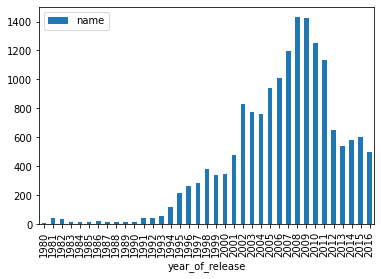

In [10]:
#сгруппируем игры по году релиза
years_of_release = pd.pivot_table(games, index=['year_of_release'], values=['name'], aggfunc=len).reset_index()
# построим график, чтобы оценить динамику
years_of_release.plot(x='year_of_release', y='name', kind='bar')

Если верить графикам, в 2008-2009 годы выпускалось очень много игр по сравнению с остальным периодом наблюдения, с 2012 года график вышел на условное плато, возможно предложение вошло в равновесие со спросом на игры.

### Как менялись продажи у разных платформ

,platform,sum_sales
0,PS2,1247.28
1,X360,961.30
2,PS3,931.34
3,Wii,891.18
4,DS,802.79
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.54
9,3DS,257.81


<AxesSubplot:xlabel='platform'>

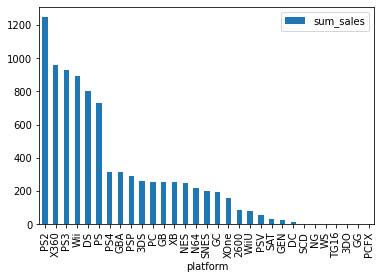

In [11]:
# группировка продаж по платформам
platforms = pd.pivot_table(games, index=['platform'], values=['sum_sales'], aggfunc=sum).reset_index()
platforms = platforms.sort_values(by='sum_sales', ascending=False).reset_index(drop=True)
display(platforms.head(10))
platforms.plot(x='platform', y='sum_sales', kind='bar')

Всего в выборке представлены 31 игровая платформа, они достаточно неоднородны по суммарным продажам выходящих на них игр. Абсолютный лидер - PS2, за ним с некоторым отставанием следуют X360, PS3,	Wii, DS, PS, затем более равномерно распределены ещё около 12 платформ, но для удобства анализа можно остановиться на топ-5.

#### Топ-5

year_of_release sum_sales                                       
platform                        DS     PC     PS2     PS3     Wii    X360
0                   1985      0.02   0.04     NaN     NaN     NaN     NaN
1                   1988       NaN   0.03     NaN     NaN     NaN     NaN
2                   1992       NaN   3.03     NaN     NaN     NaN     NaN
3                   1994       NaN  12.87     NaN     NaN     NaN     NaN
4                   1995       NaN   4.22     NaN     NaN     NaN     NaN
5                   1996       NaN  10.58     NaN     NaN     NaN     NaN
6                   1997       NaN  11.27     NaN     NaN     NaN     NaN
7                   1998       NaN   3.26     NaN     NaN     NaN     NaN
8                   1999       NaN   4.74     NaN     NaN     NaN     NaN
9                   2000       NaN   4.66   39.17     NaN     NaN     NaN
10                  2001       NaN   5.47  166.43     NaN     NaN     NaN
11                  2002       NaN   8.57  205.38     NaN     NaN     NaN
12                  2003       NaN   8.84  185.93     NaN     NaN     NaN
13                  2004     17.27  10.39  220.55     NaN     NaN     NaN
14                  2005    130.14   4.37  160.98     NaN     NaN    8.25
15                  2006    119.81   2.85  106.46   20.96  137.15   51.62
16                  2007    146.94   9.28   75.99   73.19  152.77   95.42
17                  2008    145.32  12.42   53.90  118.52  171.32  135.26
18                  2009    119.54  16.91   26.40  130.93  206.97  120.29
19                  2010     85.02  24.28    5.64  142.17  127.95  170.03
20                  2011     26.18  35.03    0.45  156.78   59.65  143.89
21                  2012     11.01  23.22     NaN  107.36   21.71   99.74
22                  2013      1.54  12.38     NaN  113.25    8.59   88.58
23                  2014       NaN  13.28     NaN   47.76    3.75   34.74
24                  2015       NaN   8.52     NaN   16.82    1.14   11.96
25                  2016       NaN   5.25     NaN    3.60    0.18    1.52

<AxesSubplot:xlabel='year_of_release'>

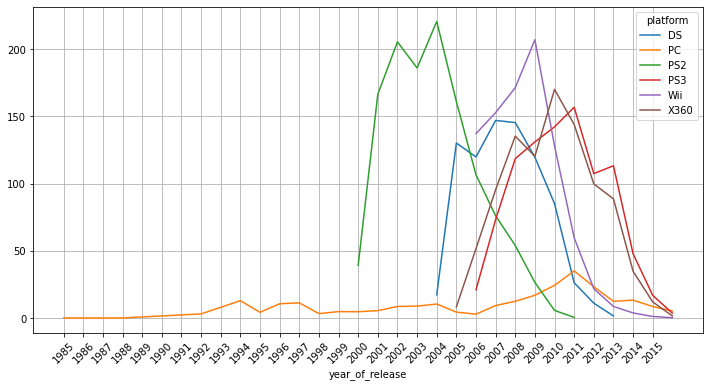

In [12]:
platforms_t5 = platforms[:5]['platform'] #топ-5 платформ
platforms_t5 = games.query('platform in @platforms_t5 or platform == "PC"') # подгрузим из остального дф данные для топ-5
platforms_t5 = pd.pivot_table(platforms_t5, index=['year_of_release'], columns = ['platform'], values=['sum_sales'], aggfunc=sum).reset_index()
display(platforms_t5)
platforms_t5.plot(x = 'year_of_release', y = 'sum_sales', grid=True, figsize=(12,6), xticks = range(1985, 2016), rot=45)

In [13]:
platforms_age = pd.pivot_table(games, index=['year_of_release'], columns = ['platform'], values=['sum_sales'], aggfunc=sum).reset_index()
display(platforms_age.count()[1:].mean()) # посчитала количество значений продаж для каждой платформы, нашла среднее
platforms_age.head() # общий вид сводной таблицы, по которой считала количество лет, в которые на платформе выпускались игры

7.67741935483871

year_of_release sum_sales                                  ...      \
platform                      2600 3DO 3DS  DC  DS  GB GBA  GC GEN  ... SAT   
0                   1980     11.38 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
1                   1981     35.68 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
2                   1982     28.88 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
3                   1983      5.84 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
4                   1984      0.27 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   

                                                   
platform SCD SNES TG16  WS Wii WiiU X360  XB XOne  
0        NaN  NaN  NaN NaN NaN  NaN  NaN NaN  NaN  
1        NaN  NaN  NaN NaN NaN  NaN  NaN NaN  NaN  
2        NaN  NaN  NaN NaN NaN  NaN  NaN NaN  NaN  
3        NaN  NaN  NaN NaN NaN  NaN  NaN NaN  NaN  
4        NaN  NaN  NaN NaN NaN  NaN  NaN NaN  NaN  

[5 rows x 32 columns]

Если верить графику, то самые крупные платформы были популярны от 6 до 9 лет. Однако из любопытства можно добавить на график персональные компьютеры, наличие которых у пользователей почти не зависит от состояния игровой индустрии. Выручка от продажи игр для ПК тоже изменялась волнообразно, она никогда не достигала пиков, характерных для крупных игровых платформ, хотя в 2011 году подъем продаж был максимальным, а затем постепенно пошел на спад. Учитывая, что прогноз нужно сделать на 2017, возьмём максимальный вариант - 9 лет, а значит, выделим данные с 2008 года.
Расчеты совпадают с данными графика, средняя продолжительность существования платформы рассчитанная на основании табличных данных - 7,5 лет.

### Данные за актуальный период

<AxesSubplot:xlabel='year_of_release'>

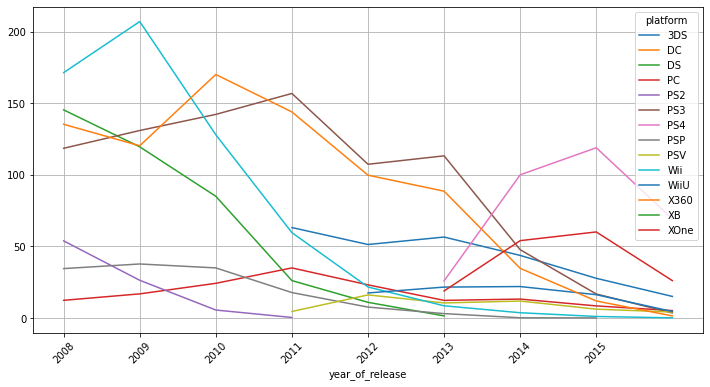

In [14]:
actual = games.query('year_of_release >= 2008')
actual_sales = pd.pivot_table(actual, index=['year_of_release'], columns = ['platform'], values=['sum_sales'], aggfunc=sum).reset_index()
actual_sales
actual_sales.plot(x = 'year_of_release', y = 'sum_sales', grid=True, figsize=(12,6), xticks = range(2008, 2016), rot=45)

Судя по графику, период в 9 лет слишком большой для анализа, на графике видно как некоторые платформы совсем теряют популярность и перестают использоватся, появляются новые. Попробуем посмотреть на период с 2011 года.

<AxesSubplot:xlabel='year_of_release'>

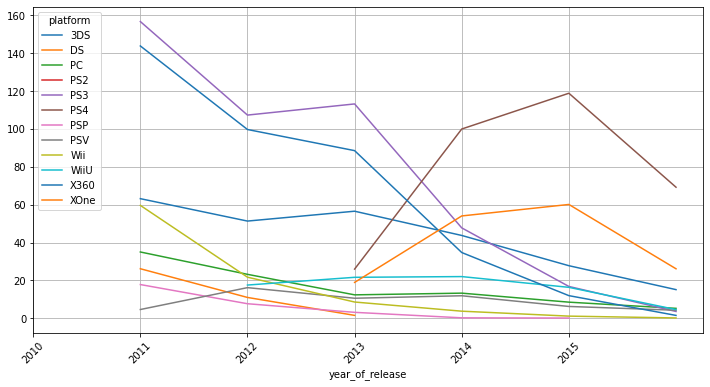

In [15]:
actual = games.query('year_of_release >= 2011')
actual_sales = pd.pivot_table(actual, index=['year_of_release'], columns = ['platform'], values=['sum_sales'], aggfunc=sum).reset_index()
actual_sales
actual_sales.plot(x = 'year_of_release', y = 'sum_sales', grid=True, figsize=(12,6), xticks = range(2010, 2016), rot=45)

На 2015 год по продажам активно растут две платформы: PlayStation4 и XBoxOne, постепенно падают продажи у остальных участников рынка: Х360, PS3, WiiU, PC, PSV, 3DS, Wii. Игры на DS, PSP и PS2 к 2015 году уже не выпускались.

In [16]:

pd.pivot_table(actual,index=['platform'], values=['sum_sales'], aggfunc=sum).sort_values(by='sum_sales', ascending=False).reset_index(drop=True)
actual_sales

year_of_release sum_sales                                             \
platform                       3DS     DS     PC   PS2     PS3     PS4    PSP   
0                   2011     63.20  26.18  35.03  0.45  156.78     NaN  17.82   
1                   2012     51.36  11.01  23.22   NaN  107.36     NaN   7.69   
2                   2013     56.57   1.54  12.38   NaN  113.25   25.99   3.14   
3                   2014     43.76    NaN  13.28   NaN   47.76  100.00   0.24   
4                   2015     27.78    NaN   8.52   NaN   16.82  118.90   0.12   
5                   2016     15.14    NaN   5.25   NaN    3.60   69.25    NaN   

                                              
platform    PSV    Wii   WiiU    X360   XOne  
0          4.63  59.65    NaN  143.89    NaN  
1         16.19  21.71  17.56   99.74    NaN  
2         10.59   8.59  21.65   88.58  18.96  
3         11.90   3.75  22.03   34.74  54.07  
4          6.25   1.14  16.35   11.96  60.14  
5          4.25   0.18   4.60    1.52  26.15

К самым потенциально прибыльным платформам за актуальный период можно отнести PS3, PS4, X360, 3DS и XOne.

,platform,name,sum_sales
736,PS3,Grand Theft Auto V,21.05


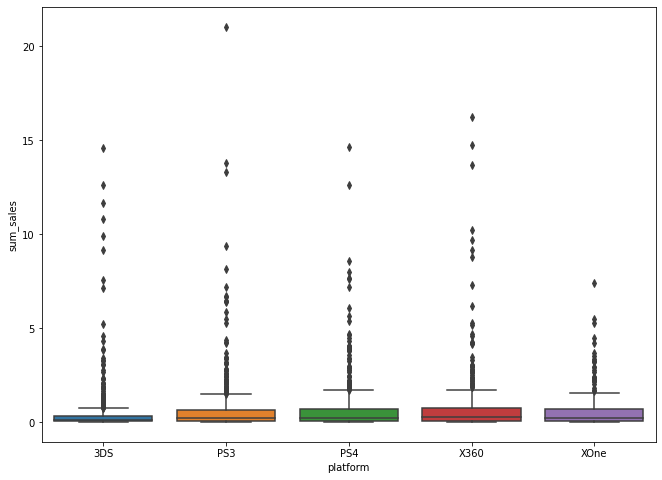

In [17]:
for_boxplots = actual.query('platform in ["PS3", "PS4", "X360", "3DS", "XOne"]')
for_boxplots = for_boxplots[['platform', 'name', 'sum_sales']].groupby(['platform', 'name']).sum().reset_index()
for_boxplots = for_boxplots.fillna(0)
f, ax = plt.subplots(figsize=(11, 8)) #чтобы хоть что-то разглядеть, увеличим график
sns.boxplot(x=for_boxplots["platform"], y=for_boxplots["sum_sales"])
#for_boxplots = for_boxplots.query('sum_sales < 6')
#sns.boxplot(x=for_boxplots["platform"], y=for_boxplots["sum_sales"])
display(for_boxplots.query('sum_sales > 20'))

Этот график сложно анализировать из-за выбросов, т.к. некоторые игры оказалась намного более успешными, чем средние по платфореме. Кроме того, если попытаться избавиться от выбросов, график станет менее точным - если убрать выбросы, среднее становится меньше. В любом случае, по средней прибыльности выпускаемых игр лидируют 3 платформы: PS3, PS4 и X360, немного отстает XOne. Самым ярким выбросом является игра GTA V на платформе PS3.

### Влияние отзывов пользователей и критиков

Для анализа влияния отзывов пользователей и критиков я выбрала одну из самых популярных платформ PS3, т.к. в период, охваченный выборкой, она уже прошла этапы появления на рынке, набора популярности, пика популярности, появления следующего поколения игровых приставок.


In [18]:
ps3 = games.query('platform == "PS3"')
ps3 = ps3[['name', 'critic_score', 'user_score', 'sum_sales']]
#ps3.info() на этом этапе нужно избавиться от пропусков в отзывах и от "tbd", чтобы привести данные к числовому формату
ps3 = ps3.replace('tbd', np.nan).dropna()
#ps3.info()
ps3.corr()

,critic_score,user_score,sum_sales
critic_score,1.000000,0.631154,0.428213
user_score,0.631154,1.000000,0.143978
sum_sales,0.428213,0.143978,1.000000


Коэффициент корреляции ни о чём существенном не говорит, т.к. зависимость скорее всего не линейная, нужно смотреть на диаграмму рассеяния.

<AxesSubplot:xlabel='user_score', ylabel='sum_sales'>

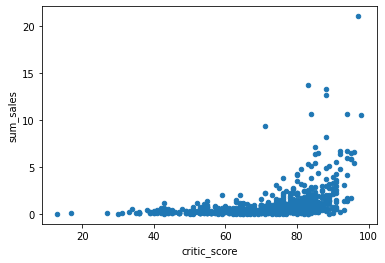

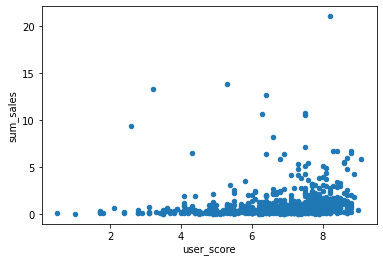

In [19]:
ps3.plot(x='critic_score', y='sum_sales', kind='scatter') # графики для ps3
ps3.plot(x='user_score', y='sum_sales', kind='scatter') 

<AxesSubplot:xlabel='user_score', ylabel='sum_sales'>

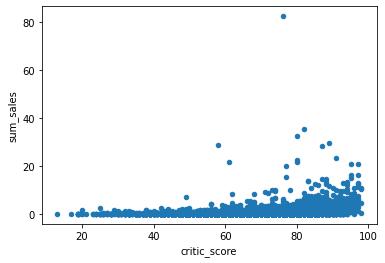

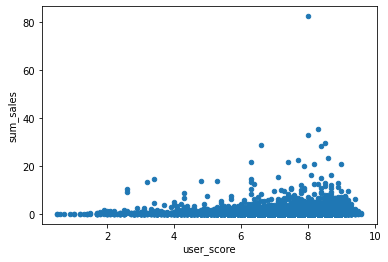

In [20]:
other = games[['name', 'critic_score', 'user_score', 'sum_sales']] #для остальных платформ
other = other.replace('tbd', np.nan).dropna()
other.corr()
other.plot(x='critic_score', y='sum_sales', kind='scatter') 
other.plot(x='user_score', y='sum_sales', kind='scatter') 

Плотность точек на диаграммах рассеяния выглядит примерно одинаково, только на общих графиках больше "случайных" точек - игр с низким рейтингом, но высокими суммарными продажами. В целом определяется тенденция к тому, что игры с высоким рейтингом (от 70 по отзывам критиков или от 7 по отзывам пользователей)продаются лучше.

### 3.5. Влияние жанра на продажи игр

<AxesSubplot:title={'center':'суммарные продажи игр по жанрам'}, xlabel='genre'>

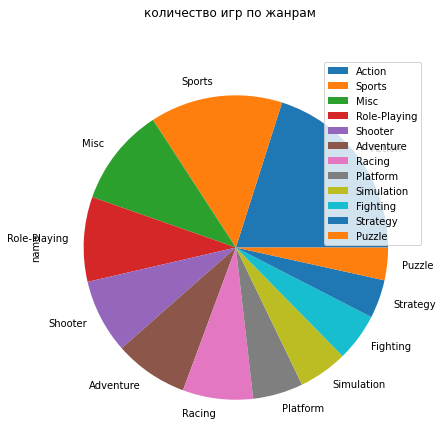

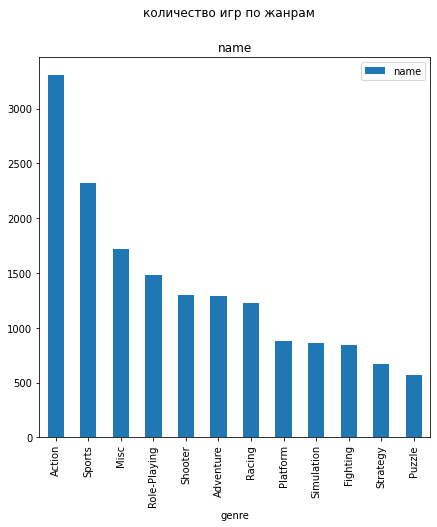

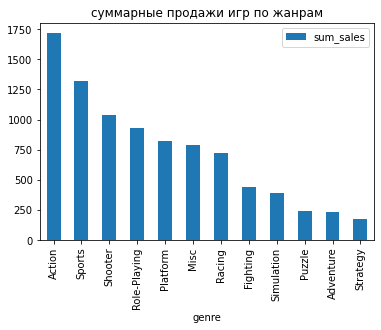

In [21]:
genres_count = pd.pivot_table(games, index=['genre'], values=['name'], aggfunc=len)
genres_sales = pd.pivot_table(games, index=['genre'], values=['sum_sales'], aggfunc=sum)
genres_count
genres_count = genres_count.sort_values(by='name', ascending=False)
genres_sales = genres_sales.sort_values(by='sum_sales', ascending=False)
genres_count.plot(kind='pie', title='количество игр по жанрам', subplots=True, figsize=(7,7))
genres_count.plot(kind='bar', title='количество игр по жанрам', subplots=True, figsize=(7,7))
genres_sales.plot(kind='bar', title='суммарные продажи игр по жанрам')

Самым популярным жанром является Action, за весь период наблюдения большая часть игр была именно в этом жанре, он же принес больше всего продаж. На втором месте и по количеству игр, и по суммарным продажам жанр Sports. Дальше - интереснее, на третем месте по продажам жанр Shooter, а по количеству игр он на пятом. Далее по количеству вышедших игр находится смешанная категория, в которую вошло, всё, что не подходит под остальные классификации. На четвертом месте и по количеству игр и по продажам - RPG. На пятом месте по продажам - Platform, хотя по количеству выходящих игр они находятся на восьмом. На шеcтом месте по количеству игр жанр Adventure, по продажам он на предпоследнем. В конце списка по продажам также находятся игры жанра Strategy и Puzzle. Заметно, что в некоторых жанрах игр выходит немного, но продаются они хорошо, или наоборот, игр много, а продаж в относительном смысле меньше. 

## 4. "Портрет" пользователей в разных регионах

### 4.1 Самые популярные платформы

,platform,eu_sales
16,PS2,337.00
17,PS3,327.21
28,X360,268.37
26,Wii,258.32
15,PS,212.39


,platform,na_sales
28,X360,595.74
16,PS2,580.30
26,Wii,486.87
17,PS3,390.13
4,DS,380.32


,platform,jp_sales
4,DS,175.02
15,PS,139.78
16,PS2,137.63
23,SNES,116.55
2,3DS,100.62


<AxesSubplot:xlabel='platform'>

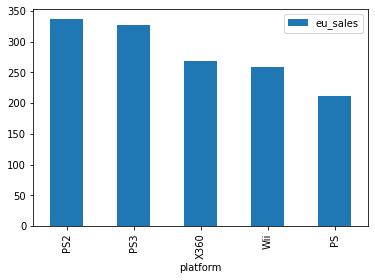

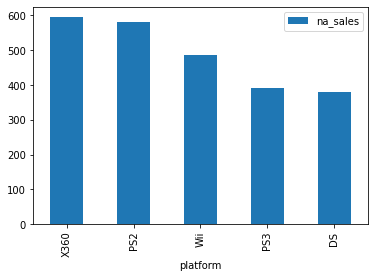

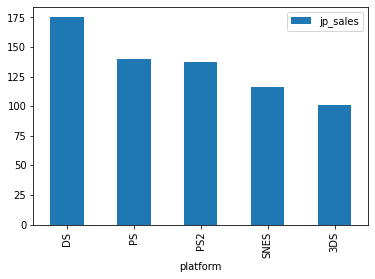

In [22]:
regions_platf= pd.pivot_table(games, index=['platform'], values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc=sum).reset_index()
eu_platf = regions_platf[['platform', 'eu_sales']].sort_values(by='eu_sales', ascending=False)
display(eu_platf.head()) # самые популярные платформы в европе
eu_platf[:5].plot(x='platform', y='eu_sales', kind='bar')

na_platf = regions_platf[['platform', 'na_sales']].sort_values(by='na_sales', ascending=False)
display(na_platf.head()) #  самые популярные платформы в Северной Америке
na_platf[:5].plot(x='platform', y='na_sales', kind='bar')

jp_platf = regions_platf[['platform', 'jp_sales']].sort_values(by='jp_sales', ascending=False)
display(jp_platf.head()) #  самые популярные платформы в Японии
jp_platf[:5].plot(x='platform', y='jp_sales', kind='bar')

Топ-5 платформ различается по регионам и это объяснимо. В Японии в топ-5 находятся платформы японских производителей Nintendo и Sony PlayStation. В Северной Америке лидирует продукт американской компании Microsoft X360, но от него ненамного отстает японский конкурент PS2. В Европе лидируют PS2 и PS3, за ними X360, а затем продукт корпорации Nintendo - Wii.

### 4.1 Самые популярные жанры

,genre,eu_sales
0,Action,510.99
10,Sports,374.38
8,Shooter,314.52
6,Racing,234.99
3,Misc,210.60


,genre,na_sales
0,Action,863.17
10,Sports,677.61
8,Shooter,584.83
4,Platform,444.44
3,Misc,399.57


,genre,jp_sales
7,Role-Playing,353.39
0,Action,160.14
10,Sports,134.98
4,Platform,130.71
3,Misc,107.02


<AxesSubplot:xlabel='genre'>

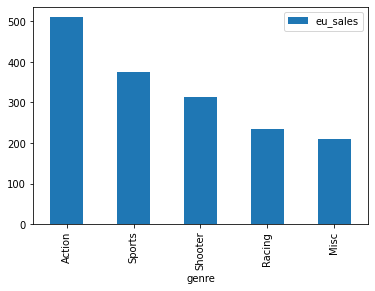

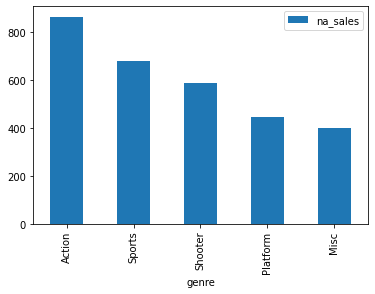

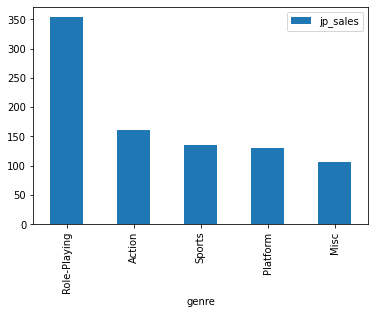

In [23]:
regions_genres = pd.pivot_table(games, index=['genre'], values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc=sum).reset_index()
eu_genres = regions_genres[['genre', 'eu_sales']].sort_values(by='eu_sales', ascending=False)
display(eu_genres.head()) # самые популярные платформы в европе
eu_genres[:5].plot(x='genre', y='eu_sales', kind='bar')

na_genres = regions_genres[['genre', 'na_sales']].sort_values(by='na_sales', ascending=False)
display(na_genres.head()) #  самые популярные платформы в Северной Америке
na_genres[:5].plot(x='genre', y='na_sales', kind='bar')

jp_genres = regions_genres[['genre', 'jp_sales']].sort_values(by='jp_sales', ascending=False)
display(jp_genres.head()) #  самые популярные платформы в Японии
jp_genres[:5].plot(x='genre', y='jp_sales', kind='bar')

Самые популярные жанры в Северной Америке и Европе практически не отличаются, наиболее популярны Action, затем Sports, затем Shooters, различается только четвертое место: в Северной Америке это Platform, в Европе Racing. В Японии всё немного по-другому, на первом месте RPG, а дальше всё почти как в Северной Америке, только без Шутеров, их вообще нет в японском топ-5 жанров. 

### 4.3 Влияние рейтинга ESRB на продажи в разных регионах?

Учитывая огромное количество пропусков в столбце с рейтингом, я не удаляла их на этапе предобработки, сейчас пришло время объединить их в группу, назовем её, "no_raiting", чтобы проанализировать влияние рейтинга на продажи по регионам.

,rating,eu_sales
1,E,707.37
8,no_raiting,610.72
5,M,480.00
7,T,421.79
2,E10+,183.35


,rating,na_sales
1,E,1281.23
8,no_raiting,1227.42
7,T,747.60
5,M,742.89
2,E10+,345.51


,rating,jp_sales
8,no_raiting,836.78
1,E,198.01
7,T,150.70
5,M,63.58
2,E10+,40.20


<AxesSubplot:xlabel='rating'>

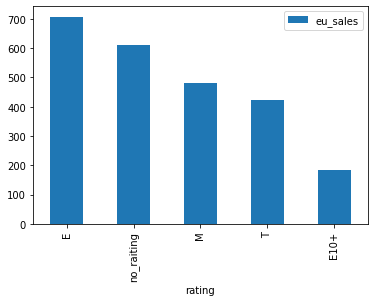

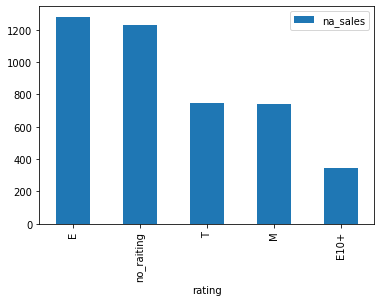

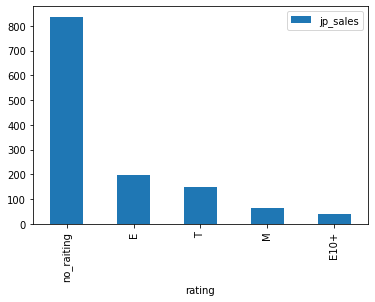

In [24]:
games['rating']= games['rating'].fillna('no_raiting') #заполнение пропусков в столбце с рейтингом
rating = pd.pivot_table(games, index=['rating'], values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc=sum).reset_index()
eu_rating = rating[['rating', 'eu_sales']].sort_values(by='eu_sales', ascending=False)
display(eu_rating.head()) # самые популярные платформы в европе
eu_rating[:5].plot(x='rating', y='eu_sales', kind='bar')

na_rating = rating[['rating', 'na_sales']].sort_values(by='na_sales', ascending=False)
display(na_rating.head()) #  самые популярные платформы в Северной Америке
na_rating[:5].plot(x='rating', y='na_sales', kind='bar')

jp_rating = rating[['rating', 'jp_sales']].sort_values(by='jp_sales', ascending=False)
display(jp_rating.head()) #  самые популярные платформы в Японии
jp_rating[:5].plot(x='rating', y='jp_sales', kind='bar')

Для игр с рейтингом Е высокие продажи во всех регионах, однако в Японии лидируют игры без рейтинга, далее следуют некоторые различия: в Европе далее следуют игры без рейтинга, а затем рейтинг М, потом за ним следует рейтинг Т. В Северной Америке рейтинг Т и М делят третье и четвертое место почти поровну, игры без рейтинга так же на второй позиции. В Японии на втором месте рейтинг Е, рейтинг Т с большим отрывом преобладает над рейтингом М. На пятой позиции во всех трех регионах находится рейтинг Е10+.

## 5. Проверка гипотез

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
Нулевая гипотеза: средние пользовательские рейтинги этих платформ равны
Альтернативная гипотеза: эти рейтинги различаются
    
2. Средние пользовательские рейтинги жанров Action и Sports разные.
Нулевая гипотеза: средние пользовательские рейтинги этих жанров равны
Альтернативная гипотеза: эти рейтинги различаются

In [25]:
#для начала подготовим выборки
user_score = games[['name', 'platform', 'genre', 'user_score']]
user_score = user_score.replace('tbd', np.nan).dropna() # на этом этапе нужно избавиться от пропусков в отзывах и от "tbd", чтобы привести данные к числовому формату

scoreXOne = user_score.query('platform == "XOne"') #отфильтруем платформу XOne
scorePC = user_score.query('platform == "PC"') #отфильтруем платформу PC
display(scoreXOne['user_score'].mean())
display(scorePC['user_score'].mean())

6.521428571428572

7.065960264900661

In [26]:
sample_1 = scoreXOne['user_score']
sample_2 = scorePC['user_score']
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.3037979620149106e-05
Отвергаем нулевую гипотезу


p-value оказался меньше заданной величины, значит разница между двумя средними статистически значима. Это говорит о том, что средний пользовательский рейтинг игр на ПК достоверно выше среднего пользовательского рейтинга игр на платформе XOne. Но, насколько известно из предыдущих исследований, на момент формирования этих данных XOne не так давно вышла на рынок видеоигр и ещё не достигла пика своей популярности, не исключено, что в ближайшие несколько лет всё поменяется.

In [27]:
scoreAction = user_score.query('genre == "Action"') #отфильтруем жанр Action
scoreSport = user_score.query('genre == "Sports"') #отфильтруем жанр Sports
display(scoreAction['user_score'].mean())
display(scoreSport['user_score'].mean())

7.058129175946549

6.959466911764705

In [28]:
sample_1 = scoreAction['user_score']
sample_2 = scoreSport['user_score']
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.08705378146247714
Не получилось отвергнуть нулевую гипотезу


А вот здесь результат неоднозначный, т.к. при p = 0,05 статистически значимой разницы нет, а при p = 0,1 - есть. С другой стороны, альфа = 0,05 это общепринятый порог и с ним точность исследования выше, чем при пороге в 0,1. При альфа равном 0,1 с вероятностью 10% среднее выборки просто случайно оказалось так далеко от среднего генеральной совокупности, т.к. средние выборок нормально распределены вокруг среднего генеральной совокупности. Оставим альфа равным 0,05 и не будем отвергать нулевую гипотезу. Средние пользовательские рейтинги жанров Action и Sport примерно равны.

## 6. Общий вывод

Проведен анализ данных о компьютерных играх за период с 1980 года по 2016 год. Выяснилось, что количесво выпускаемх игр с 1980 г непрерывно росло, достигло пика в 2008-2009 гг, а затем постепенно стало уменьшаться. Спад в 2016 г, который видно на графике - всего лишь следствие неполноты данных за 2016 год. Топ-5 платформ по количеству продаж:  PS2, X360, PS3, Wii, DS, PS. По графикам виден "жизненный цикл" каждой игровой платформы: когда она повилась, начала набирать популярность, достигла пика, а затем постепенно стала терять популярность, и появилось следующее поколение платформ. Этот цикл занимает примерно от 6 до 9 лет, поэтому за актуальный период взят промежуток в 6 лет с 2010 до 2016 год. На 2015г самые активно развивающиеся платформы это PS4 и XOne.
На продажи игр кроме платформы ещё влияет множество факторов: есть зависимость между отзывами критиков и игроков, не прямая корреляция, но диаграммы рассеяния указываю на имеющуюся связь. Есть также данные о связи с жанром, самым популярным жанром является Action, на втором месте и по количеству игр, и по суммарным продажам жанр Sports, затем по продажам следует жанр Shooter. Короме того, наиболее популярные платформы и жанры различаются по регионам. В Японии лидируют японские приставки Sony PlayStation и Nintendo, в Америке более популярна американская приставка XBox, а в Европе примерно поровну используют и те, и другие. Кроме того есть различия по жанрам и рейтингам, популярным в разных регионах. 
Гипотеза о равенстве средних оценок игр на ПК и XBox One была отвергнута, разница между средними есть и она статистически значима. А вот гипотеза о различии продаж игр жанра Action и Sports c большой вероятостью неверна, т.к. разница средних небольшая и статистически не значимая.